In [1]:
# On commence par importer les bibliothèques nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import neighbors

### Introduction

L'objectif de cette activité est d'améliorer le score de la baseline, c'est-à-dire la régression linéaire sur la seule variable Surface, pour prédire des loyers d'appartements. Pour cela, on essaiera  successivement: <br>
* **L'ajout d'une variable Arrondissement**, et une régression linéaire sur les deux variables Surface et Arrondissement telles quelles.<br><br>
* **La modification de la variable Arrondissement pour qu'elle ne soit pas traitée par le modèle comme une variable numérique, mais comme une catégorie.** <br>On fera alors tourner une nouvelle régression linéaire qui conduira à une droite de régression pour chaque arrondissement. Ces droites:
    * Auront le même coefficient directeur
    * Mais leur terme constant pourra varier.<br><br>
* **On tentera ensuite le modèle complémentaire, permettant d'obtenir une droite par arrondissement, ces droites ayant:**
    * Des coefficients directeurs différents
    * Le même terme constant.<br><br>
* **Enfin, on essaiera un modèle revenant à 5 régressions linéaires indépendantes**, une pour chaque arrondissement, avec la pente de la régression et le terme constant variant en fonction de l'arrondissement.

L'inconvénient des deux derniers modèles est qu'il seront inopérants pour les arrondissements inconnus, c'est-à-dire absents du set d'entraînement.


### 1. Chargement, nettoyage et exploration préliminaire des données

On commence par charger les données dans une dataframe pandas.<br>
On nettoie ensuite les données chargées en retirant les lignes contenant des **na**.<br>
On sépare ensuite les données en un set d'entraînement et un set de test.<br>

On affiche ensuite un graphe des données avec:
* La surface en abscisse
* Le loyer en ordonnée
* L'arrondissement traduit par la couleur du point. 

In [2]:
# On charge les données
data = pd.read_csv('house_data.csv')

# On explore les données
print(data.head())

arrondissements = [a for a in set(data['arrondissement']) if str(a) != 'nan']

print('\nIl y a {} arrondissements.'.format(len(arrondissements)))
print('Il y a {} observations.'.format(data.shape[0]))
print('Il y a {} variables (hormis la colonne \'price\' à prédire).'.format(data.shape[1]-1))

# On nettoie les données
data.dropna(inplace=True)

# Séparation des données en un set d'entraînement et un set de test.
features = data[['surface', 'arrondissement']]
target = data['price']
xtrain, xtest, ytrain, ytest = train_test_split(features, target, 
                                                train_size=0.8, test_size=0.2,
                                                random_state=10000)

   price  surface  arrondissement
0   1820     46.1             1.0
1   1750     41.0             1.0
2   1900     55.0             1.0
3   1950     46.0             1.0
4   1950     49.0             1.0

Il y a 5 arrondissements.
Il y a 827 observations.
Il y a 2 variables (hormis la colonne 'price' à prédire).


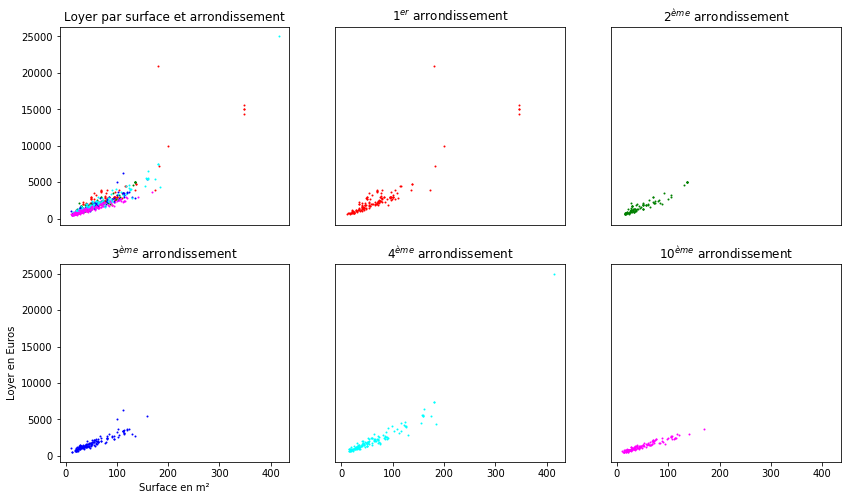

In [3]:
# On visualise les données.
# On utilisera cette fonction également plus tard, 
# pour visualiser les droites de régression.

def afficher_graphe(dataset, model=None, intercept=None, coef=None):
    """
    Afficher un scatter plot des données, avec:
    - la surface en abscisse
    - le loyer en ordonnée
    - on traduit l'arrondissement à travers la couleur du point
    - la droite de régression obtenue pour chaque arrondissement.
    """
    
    mapping = {1:1, 2:2, 3:3, 4:4, 5:10}
    
    names = {1: '$1^{er}$ arrondissement',
             2: '$2^{ème}$ arrondissement',
             3: '$3^{ème}$ arrondissement',
             4: '$4^{ème}$ arrondissement',
             5: '$10^{ème}$ arrondissement'}
    
    colors = {1: 'red', 2: 'green', 3: 'blue', 4: 'cyan', 5: 'magenta'}
    
    f, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(14, 8))
    
    axes[0, 0].set_title('Loyer par surface et arrondissement')
    axes[0, 0].xaxis.set_visible(False)
    axes[1, 0].set_xlabel('Surface en m²')
    axes[1, 0].set_ylabel('Loyer en Euros')
    
    for k in mapping:
        if model == 'categ':
            feature = 'surface'
            subset = dataset[dataset['arrondissement_{}'.format(mapping[k])] != 0]
        elif model == 'surf':
            feature = 'arrondissement_{}'.format(mapping[k])
            subset = dataset[dataset[feature] != 0]
        else:
            feature = 'surface'
            subset = dataset[dataset['arrondissement'] == mapping[k]]
        
        axes[0, 0].scatter(x=subset[feature], y=subset['price'], c=colors[k], s=1, label=names[k])
        
        row = k // 3
        col = k % 3
        
        axes[row, col].scatter(x=subset[feature], y=subset['price'], c=colors[k], s=1, label=names[k])
        
        if model:
            first_point = intercept
            if model == 'categ':
                second_point = intercept + coef[0] * 250 + coef[k]
            elif model == 'surf':
                second_point = intercept + coef[k-1] * 250  
            axes[row, col].plot([0, 250], [first_point, second_point], c=colors[k])
        
        axes[row, col].set_title(names[k])
        axes[row, col].xaxis.set_visible(row!=0)
        axes[row, col].yaxis.set_visible(col==0) 
        
    plt.show()
    
dataset = xtrain.copy()
dataset['price'] = ytrain.copy()
afficher_graphe(dataset)

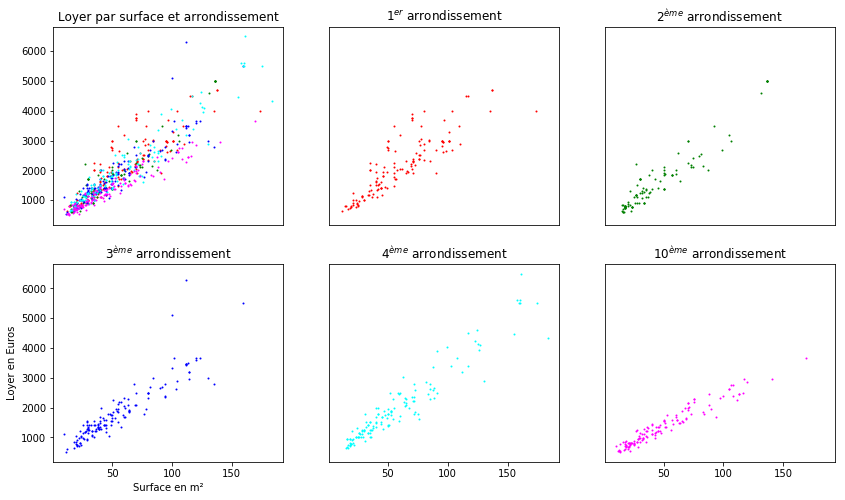

In [4]:
# On voit qu'au-delà de 7000 euros, on n'a plus assez de données 
# pour faire apparaître une relation claire entre les variables. 
# On se concentre donc sur les loyers de moins de 7000 euros.
dataset = dataset[dataset['price']<=7000]

xtrain = dataset[[c  for c in list(dataset.columns[:]) if c != 'price']]
ytrain = dataset['price']

# On réaffiche le graphe 
afficher_graphe(dataset)

#### Conclusions tirées de l'exploration 
On observe que, pour un arrondissement donné, la relation entre le loyer et la surface semble linéaire. <br><br>
Certains arrondissements apparaîssent plus chers que d'autres. Par exemple, le $10^{ème}$ arrondissement présente des prix plus bas que les autres pour une même surface.<br><br>
La variance des loyers dépend également de l'arrondissement considéré; le premier arrondissement est celui dont le prix au $m²$ semble le moins clairement défini. Sur le jeu de données observé, il peut varier du simple au double. 
<br><br>

#### Baseline
L'objectif de cette activité est d'améliorer le score de la prédiction par rapport au score de la baseline, c'est-à-dire de la régression linéaire avec une seule feature. Avant de proposer des améliorations, on ré-entraîne donc la baseline sur le set d'entraînement, et on récupère son score.

In [5]:
# On retire du dataset les loyers supérieurs à 7000 euros, 
# sur lesquels on ne pourra de toute manière pas prédire correctement. 
testset = xtest.copy()
testset['price'] = ytest
testset = testset[testset['price']<=7000]
xtest = testset[[c  for c in list(testset.columns[:]) if c != 'price']]
ytest = testset['price']

# On fitte la baseline sur la variable 'surface'. 
xtrain_baseline = xtrain[['surface']]
xtest_baseline = xtest[['surface']]
baseline = linear_model.LinearRegression()
baseline.fit(xtrain_baseline, ytrain)

# On affiche le score sur le set de test.
s_baseline = baseline.score(xtest_baseline, ytest)
msg = 'Score de la baseline, sur les données de test:'
msg = '\n' + msg + ' {0:.6f}\n'
print(msg.format(s_baseline))


Score de la baseline, sur les données de test: 0.852604



### 2. Régression linéaire sur les deux variables
On fitte une régression linéaire sur le set d'entraînement. On entraîne le modèle sur les deux variables, surface et arrondissement.

In [6]:
# On fitte une régression linéaire sur les deux variables. 
regr = linear_model.LinearRegression()
regr.fit(xtrain, ytrain)

# On récupère les coefficients retournés par le modèle
print('\nCoefficients obtenus par régression linéaire sur deux variables:\n')
print(' - Terme constant: {0:.2f}'.format(regr.intercept_))
for i in range(2):
    print(' - Coefficient {0}: {1:.2f}'.format(i + 1, regr.coef_[i]))

# On affiche le score sur le set de test.
s_regr = regr.score(xtest, ytest)
msg = 'Score de la régression linéaire sur deux variables, '
msg += 'sur les données de test:'
msg = '\n' + msg + ' {0:.6f}'
print(msg.format(s_regr))


Coefficients obtenus par régression linéaire sur deux variables:

 - Terme constant: 529.78
 - Coefficient 1: 27.73
 - Coefficient 2: -51.81

Score de la régression linéaire sur deux variables, sur les données de test: 0.868400


### 3. On catégorise la variable Arrondissement

Pour tenter d'améliorer le modèle, on transforme la variable *Arrondissement*, qui ne doit pas être comprise par les modèles comme une variable numérique mais comme une variable de catégorie. <br><br>
En effet, le modèle ne doit pas fonder sa prédiction sur une perception numérique de la variable *Arrondissement*. Par exemple, cela n'aurait aucun sens de considérer que l'arrondissement 4 est égal à deux fois l'arrondissement 2. <br><br>
Pour éviter cela, au lieu de garder une seule variable avec la donnée de l'arrondissement (1, 2, 3, 4, ou 10), on crée 5 variables, une par arrondissement. Si l'observation concerne l'arrondissement 1, la première variable sera à 1 et les autres à 0.<br><br>   Voici un lien avec plus d'explications : https://blog.cambridgespark.com/robust-one-hot-encoding-in-python-3e29bfcec77e<br><br>

In [7]:
# On transforme la variable arrondissement en une variable de catégorie. 
xtrain = xtrain.copy()
xtrain['arrondissement'] = xtrain['arrondissement'].astype(int)
xtrain = pd.get_dummies(xtrain, prefix_sep="_", columns=['arrondissement'])

# On sauvegarde la liste des nouvelles variables 
# ainsi que la liste des colonnes du training set.
# On s'en servira au moment de l'utilisation du set de test. 
processed_columns = list(xtrain.columns)
dummies_columns = [c for c in processed_columns if '_' in c]

# On fitte une régression linéaire sur les set d'entraînement. 
regr_categ = linear_model.LinearRegression()
regr_categ.fit(xtrain, ytrain)

# On récupère les coefficients retournés par le modèle
print('\nCoefficients obtenus après traitement de la variable Arrondissement:\n')
print(' - Terme constant: {0:.2f}'.format(regr_categ.intercept_))
for i in range(5):
    print(' - Coefficient {0}: {1:.2f}'.format(i + 1, regr_categ.coef_[i]))

# On souhaite afficher le score du modèle sur le set de test.
# Pour cela, on doit faire subir au set de test les mêmes
# transformations qu'au set d'entraînement.

# Donc, notamment : la transformation de la variable 'arrondissement'
# Le problème à prendre en compte est que de nouveaux arrondissements 
# peuvent arriver dans les données de test.

# Pour pallier ce problème, on procède comme expliqué ici:
# https://blog.cambridgespark.com/robust-one-hot-encoding-in-python-3e29bfcec77e
# On transforme la variable arrondissement en une variable de catégorie. 
xtest = xtest.copy()
xtest['arrondissement'] = xtest['arrondissement'].astype(int)
xtest = pd.get_dummies(xtest, prefix_sep="_", columns=['arrondissement'])

# On enlève les colonnes non présentes dans xtrain
for col in xtest.columns:
    if "_" in col and col not in dummies_columns:
        xtest.drop(col, axis=1, inplace=True)

# On ajoute les colonnes présentes dans xtrain, et on les emplit de 0.
for col in dummies_columns:
    if col not in xtest.columns:
        xtest[col] = 0
        
# On met les colonnes dans le même ordre que dans xtrain.
xtest = xtest[processed_columns]

# On affiche le score du modèle avec la variable 
# arrondissement "catégorisée" sur le set de test.
s_regr_categ = regr_categ.score(xtest, ytest)
msg = 'Score de la régression linéaire avec la variable '
msg += 'arrondissement catégorisée, \nsur les données de test:'
msg = '\n' + msg + ' {0:.6f}'
print(msg.format(s_regr_categ))


Coefficients obtenus après traitement de la variable Arrondissement:

 - Terme constant: 329.15
 - Coefficient 1: 27.57
 - Coefficient 2: 175.30
 - Coefficient 3: 58.46
 - Coefficient 4: 0.72
 - Coefficient 5: 88.01

Score de la régression linéaire avec la variable arrondissement catégorisée, 
sur les données de test: 0.873339


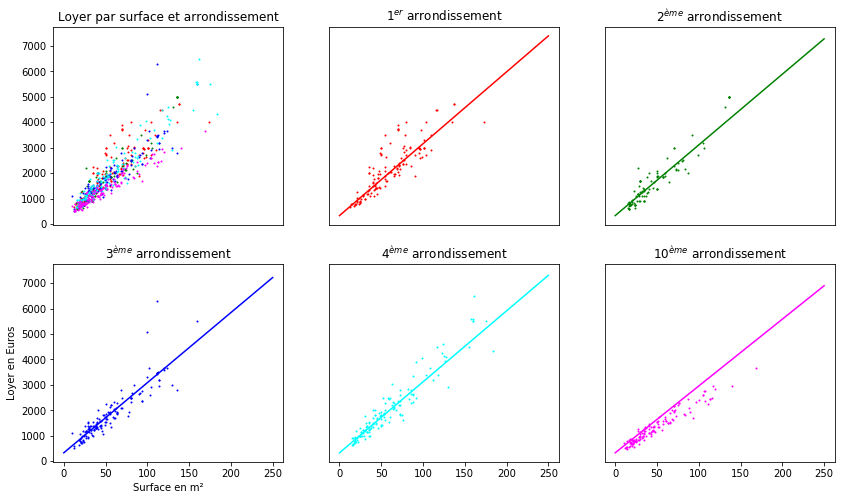

In [8]:
# On visualise les données avec la droite de régression.    
# On affiche le graphe du début avec les droites obtenues pour chaque arrondissement.
dataset = xtrain.copy()
dataset['price'] = ytrain.copy()
afficher_graphe(dataset, 'categ', regr_categ.intercept_, regr_categ.coef_)

### 4. Cinq régressions linéaires mais avec le même terme constant
Dans le paragraphe précédent, on a choisi pour modèle une régression linéaire sur 6 variables: <br>
* Surface
* Et les 5 variables 'booléennes' arrondissement_i.

Pour une observation donnée, une seule variable arrondissement_i sera à 1, et les autres à 0. <br>La prédiction sera donc: <br>
**loyer = COEF_0 + COEF_surface \* surface + COEF_arr_i \* 1**

Cette formule revient à :<br>
**loyer = (COEF_0 + COEF_arr_i) + COEF_surface * surface**

Donc, par ce procédé, la pente de la droite de régression est la même pour tous les arrondissements. Or on constate que c'est clairement faux pour l'arrondissement 10 (en rose ci-dessus): la pente de la régression devrait être plus faible pour cet arrondissement. <br>
Pour résoudre ce problème, on va:
* Multiplier les variables 'arrondissement_i' par la surface de l'observation.<br>
  Ces variables ne seront donc plus des variables booléennes.
* Retirer la variable Surface
* Puis relancer une régression linéaire sur ces 5 variables. 

Cette solution va presque revenir à faire cinq régressions linéaires, une par arrondissement, avec pour seule différence qu'elles auront toutes le même terme constant. Dans notre cas, ça fonctionne mieux que la solution du dessus, mais le désavantage est qu'on ne pourra plus faire de prédiction sur un arrondissement non présent dans le set d'entraînement. 

In [9]:
# On multiplie les variables arrondissement_i par la surface. 
mapping = {1:1, 2:2, 3:3, 4:4, 5:10}
reverse_mapping = {1:1, 2:2, 3:3, 4:4, 10:5}

for i in range(5):
    arr = 'arrondissement_{}'.format(mapping[i + 1])
    xtrain[arr] = xtrain[arr] * xtrain['surface']

xtrain = xtrain[[c for c in xtrain.columns.values if 'arr' in c]]

# On fitte une régression linéaire sur les set d'entraînement. 
regr_surf = linear_model.LinearRegression()
regr_surf.fit(xtrain, ytrain)

# On récupère les coefficients retournés par le modèle
print('\nCoefficients après multiplication des variables arr_i par la surface:\n')
print(' - Terme constant: {0:.2f}'.format(regr_surf.intercept_))
for i in range(4):
    print(' - Coefficient {0}: {1:.2f}'.format(i + 1, regr_surf.coef_[i]))

# On traite le set de test
for i in range(5):
    arr = 'arrondissement_{}'.format(mapping[i + 1])
    xtest[arr] = xtest[arr] * xtest['surface']

xtest = xtest[[c for c in xtest.columns.values if 'arr' in c]]

# On affiche le score du modèle avec la variable 
# arrondissement "catégorisée" sur le set de test.
s_regr_surf = regr_surf.score(xtest, ytest)
msg = 'Score de la régression linéaire avec les variables '
msg += 'arrondissement_i \nmultipliées par la surface, sur les données de test:'
msg = '\n' + msg + ' {0:.6f}'
print(msg.format(s_regr_surf))


Coefficients après multiplication des variables arr_i par la surface:

 - Terme constant: 324.21
 - Coefficient 1: 30.01
 - Coefficient 2: 29.90
 - Coefficient 3: 27.65
 - Coefficient 4: 29.42

Score de la régression linéaire avec les variables arrondissement_i 
multipliées par la surface, sur les données de test: 0.878581


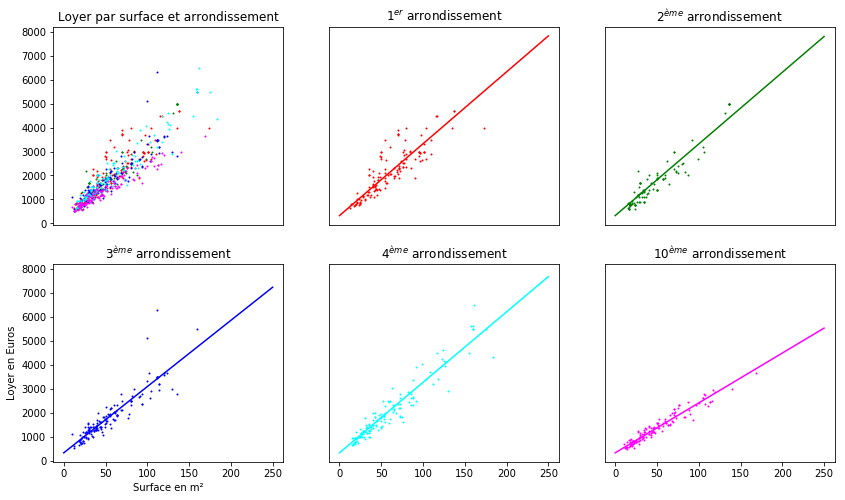

In [10]:
# On visualise les données avec la droite de régression.
# On affiche le graphe du début avec les droites obtenues pour chaque arrondissement.
dataset = xtrain.copy()
dataset['price'] = ytrain.copy()
afficher_graphe(dataset, 'surf', regr_surf.intercept_, regr_surf.coef_)

### 5. Cinq régressions linéaires 
La dernière chose que l'on va essayer est de lancer une régression linéaire par arrondissement. Ni le terme constant ni la pente ne sont communs d'un arrondissement à l'autre: les régressions sont indépendantes.

In [11]:
dataset_train = xtrain.copy()
dataset_train['price'] = ytrain.copy()

dataset_test = xtest.copy()
dataset_test['price'] = ytest.copy()

regr = {}
u = 0

# On fitte une régression linéaire par arrondissement 
for i in range(5):
    
    arr = 'arrondissement_{}'.format(mapping[i + 1])
    dataset_train_i = dataset_train[dataset_train[arr] != 0]
    xtrain_i = dataset_train_i[[c for c in dataset_train_i.columns.values if 'arr' in c]]
    ytrain_i = dataset_train_i[['price']]
    regr[i] = linear_model.LinearRegression()
    
    # On fitte le modèle pour cet arrondissement
    regr[i].fit(xtrain_i, ytrain_i)
    
    # On calcule la quantité u pour cet arrondissement sur le set de test
    # Cette quantité va servir à calculer le score du modèle global
    dataset_test_i = dataset_test[dataset_test[arr] != 0]
    xtest_i = dataset_test_i[[c for c in dataset_test_i.columns.values if 'arr' in c]]
    ytest_i = dataset_test_i[['price']]
    ypred_i = regr[i].predict(xtest_i)
    u += ((ytest_i - ypred_i) ** 2).sum()
    
    
# On calcule le score global sur le set de test.
# On utilise la formule trouvée pour score dans l'aide en ligne de sklearn. 
v = ((ytest - ytest.mean()) ** 2).sum()
s_5_regr = float(1 - u/v)  

# On affiche le score sur le set de test.
msg = 'Score du modèle combinant 5 régressions linéaires indépendantes, sur les données de test:'
msg = '\n' + msg + ' {0:.6f}\n'
print(msg.format(s_5_regr))


Score du modèle combinant 5 régressions linéaires indépendantes, sur les données de test: 0.885436



### 6. Comparaisons avec la baseline et conclusion

Comme précisé plus haut, la baseline est la régression linéaire n'utilisant qu'une seule variable, la surface. On compare les scores des modèles obtenus précédemment avec celui de la baseline.

In [12]:
# Comparaison avec le score de la régression linéaire avec les deux variables
msg = 'Avec la régression linéaire basique:\n - sur deux variables, '
msg += '\n - sans traitement de la variable \'arrondissement\',\n'
msg += '=> On obtient un score de {0:.6f}.\n'
msg += '=> Le score de la baseline est augmenté de {1:.6f}%.\n'
print(msg.format(s_regr, 100*(s_regr - s_baseline)))

# Comparaison avec le score de la régression linéaire: 
# - Avec les deux variables
# - Avec la variable arrondissement 'catégorisée'
msg = 'Avec la régression linéaire:\n - sur deux variables, '
msg += '\n - avec catégorisation de la variable \'arrondissement\',\n'
msg += '=> On obtient un score de {0:.6f}.\n'
msg += '=> Le score de la baseline est augmenté de {1:.6f}%.\n'
print(msg.format(s_regr_categ, 100*(s_regr_categ - s_baseline)))

# Comparaison avec le score du modèle consistant en 5 régressions 
# linéaires de même terme constant
msg = 'Avec le modèle consistant en 5 régressions linéaires: \n'
msg += ' - de même terme constant,\n'
msg += ' - de pentes indépendantes,\n'
msg += '=> On obtient un score de {0:.6f}.\n'
msg += '=> Le score de la baseline est augmenté de {1:.6f}%.\n'
print(msg.format(s_regr_surf, 100*(s_regr_surf - s_baseline)))

# Comparaison avec le score du modèle consistant en 5 régressions linéaires indépendantes
msg = 'Avec le modèle consistant en 5 régressions linéaires indépendantes:\n'
msg += '=> On obtient un score de {0:.6f}.\n'
msg += '=> Le score de la baseline est augmenté de {1:.6f}%.\n'
print(msg.format(s_5_regr, 100*(s_5_regr - s_baseline)))

Avec la régression linéaire basique:
 - sur deux variables, 
 - sans traitement de la variable 'arrondissement',
=> On obtient un score de 0.868400.
=> Le score de la baseline est augmenté de 1.579538%.

Avec la régression linéaire:
 - sur deux variables, 
 - avec catégorisation de la variable 'arrondissement',
=> On obtient un score de 0.873339.
=> Le score de la baseline est augmenté de 2.073441%.

Avec le modèle consistant en 5 régressions linéaires: 
 - de même terme constant,
 - de pentes indépendantes,
=> On obtient un score de 0.878581.
=> Le score de la baseline est augmenté de 2.597616%.

Avec le modèle consistant en 5 régressions linéaires indépendantes:
=> On obtient un score de 0.885436.
=> Le score de la baseline est augmenté de 3.283108%.



En conclusion, voici les essais effectués:
* Ajout de la variable 'arrondissement',
* Transformation de la variable 'arrondissement' en 5 variables booléennes,
* Multiplication des 5 variables par la surface,
* Fit d'une régression linéaire indépendante par arrondissement.

La dernière stratégie a permis d'obtenir le score le plus élevé : 0.885436.